# Introduction

Music plays a big role in our lives and forms a billion dollar industry. A lot of research goes into
music recommendation and prediction especially with so many internet radio services coming
up like Spotify, Pandora etc.
Most of the music recommender systems have songs recommended by similar songs to the users based on peer user's choices, from keywords of music such as genre, year or musician to predict similar songs.

Often times user might be looking for similar songs based on song characteristics such as how acoustic and loud song is.

We can incorporate these high level audio features like Acoustiness, Danceability, Energy, Instrumentalness etc to improve user experience with recommending related music.

The objective of this project is to segment songs into different clusters based on high level audio features. This algorithm is helpful to recommend a set of songs that best fits user interests. As a next step, We should be able to create a recommender engine which takes in a playlist and  classify it to right groupand returns similar songs in the cluster.

# Dataset: The Free Music Archive

The Free Music Archive (FMA) is an assembly of over 100,000 clips of 30
seconds from music tracks as well as pre-extracted data from them, including a hierarchy
of 161 total genres derived from 16 top-level categories (Defferard, M. Benzi, K.
Vandergheynst, P. Bresson, X, 2017). The archive contains both high-level audio features
of approximately 13,000 of its tracks through the Spotify API, and a collection of lowlevel features from all clips collected directly from each clip’s audio spectrogram in the
form of Mel-Frequency Cepstral Coefficients.

**In this project, we will be experimenting using high level audio data collected from Spotify.**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import IPython.display as ipd

import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn import  metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.cluster import KElbowVisualizer
from itertools import permutations
from sklearn.preprocessing import MinMaxScaler



In [2]:
!pip install umap-learn
import umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 35.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c581cf3e46f1a6e578c77c3982a7e266ba0c5f20dadca4982a0360dc09531308
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=266534b91415628a34f6365e02bb367a00d51f07f74e775e44b5bb2a3a2c9b19
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
spotify_link = 'https://drive.google.com/file/d/1Rq3r6v8NoDKTezTpkTI2erl086t7Y5rr/view'

s_id = spotify_link.split("/")[-2]
s_downloaded = drive.CreateFile({'id':s_id})

s_downloaded.GetContentFile('spotify.csv') 
spotify_df = pd.read_csv('spotify.csv', index_col=0, header=[0, 1, 2])

# EDA

The Spotify dataframe is a multi index df which containsaudio features for 13129 music tracks

In [ ]:
spotify_df.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

From the spotify_df, We will be using only 8 features which are audio features as mentioned below.

In [ ]:
audio_features = spotify_df['echonest']['audio_features']

In [ ]:
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 2 to 124911
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      13129 non-null  float64
 1   danceability      13129 non-null  float64
 2   energy            13129 non-null  float64
 3   instrumentalness  13129 non-null  float64
 4   liveness          13129 non-null  float64
 5   speechiness       13129 non-null  float64
 6   tempo             13129 non-null  float64
 7   valence           13129 non-null  float64
dtypes: float64(8)
memory usage: 923.1 KB


We have 8 high level audio features of music data collected from Spotify

In [ ]:
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 2 to 124911
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      13129 non-null  float64
 1   danceability      13129 non-null  float64
 2   energy            13129 non-null  float64
 3   instrumentalness  13129 non-null  float64
 4   liveness          13129 non-null  float64
 5   speechiness       13129 non-null  float64
 6   tempo             13129 non-null  float64
 7   valence           13129 non-null  float64
 8   x                 13129 non-null  float64
 9   y                 13129 non-null  float64
 10  cluster           13129 non-null  int32  
dtypes: float64(10), int32(1)
memory usage: 1.2 MB


In [ ]:
audio_features.isna().sum()

acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
x                   0
y                   0
cluster             0
dtype: int64

It seems like there are no null values in the dataset

In [ ]:
audio_features.corr()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
acousticness,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


# **Baselines**

Let's build baseline models considering all the given features and evaluate the performance of those models



In [ ]:
audio_features = spotify_df['echonest']['audio_features']
# Standardizing the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
audio_features_std = scaler.fit_transform(audio_features)

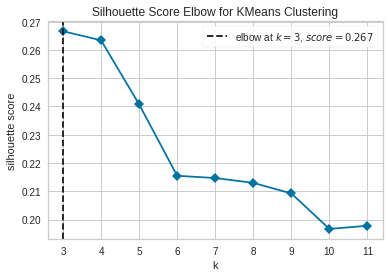

In [ ]:
#  Apply k-means on the dataset by setting different k-values and get the silhouette scores
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,12), metric='silhouette', timings=False)
visualizer.fit(audio_features_std)
score = visualizer.elbow_score_
value = visualizer.elbow_value_
visualizer.show()

In [ ]:
 # Defining the agglomerative clustering using complete linkage method
clusters = [3, 4, 5, 6]
for cluster in clusters:
  agg_cluster = AgglomerativeClustering(linkage='complete', 
                                        affinity='cosine',
                                        n_clusters=cluster)
  # Fit model
  clusters = agg_cluster.fit_predict(audio_features_std)
  # evaluate model using silhouette score
  print("The silhouette score of the Agglomerative {} clusters solution - complete linkage method: {}"
        .format(cluster, metrics.silhouette_score(audio_features_std, clusters, metric='euclidean')))
  print("------------------------------------------------")


  # Defining the agglomerative clustering using ward linkage method
  agg_cluster = AgglomerativeClustering(linkage='ward', 
                                        affinity='euclidean',
                                        n_clusters=cluster)
  # Fit model
  clusters = agg_cluster.fit_predict(audio_features_std)
  # evaluate model using silhouette score
  print("The silhouette score of the Agglomerative {} cluster solution - ward linkage method: {}"
        .format(cluster, metrics.silhouette_score(audio_features_std, clusters, metric='euclidean')))
  print("------------------------------------------------")


  # Defining the agglomerative clustering using average linkage method
  agg_cluster = AgglomerativeClustering(linkage='average', 
                                        affinity='cosine',
                                        n_clusters=cluster)
  # Fit model
  clusters = agg_cluster.fit_predict(audio_features_std)
  # evaluate model using silhouette score
  print("The silhouette score of the {} Agglomerative cluster solution - average linkage method: {}"
        .format(cluster, metrics.silhouette_score(audio_features_std, clusters, metric='euclidean')))
  print("------------------------------------------------")

The silhouette score of the Agglomerative 3 clusters solution - complete linkage method: 0.17210909505607444
------------------------------------------------
The silhouette score of the Agglomerative 3 cluster solution - ward linkage method: 0.2302733581486484
------------------------------------------------
The silhouette score of the 3 Agglomerative cluster solution - average linkage method: 0.2365067742820074
------------------------------------------------
The silhouette score of the Agglomerative 4 clusters solution - complete linkage method: 0.18234789866362547
------------------------------------------------
The silhouette score of the Agglomerative 4 cluster solution - ward linkage method: 0.22567093945410652
------------------------------------------------
The silhouette score of the 4 Agglomerative cluster solution - average linkage method: 0.18485573664256855
------------------------------------------------
The silhouette score of the Agglomerative 5 clusters solution - comp

In [ ]:
covariance_types = ['full', 'tied', 'diag', 'spherical']
for covariance_type in covariance_types:
  gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type=covariance_type)

  # Fit model
  clusters = gmm_cluster.fit_predict(audio_features_std)
  # evaluate model using silhouette score
  print("The silhouette score of the GMM solution  of covariance_type {}: {}"
        .format(covariance_type, metrics.silhouette_score(audio_features_std, clusters, metric='euclidean')))

The silhouette score of the GMM solution  of covariance_type full: 0.05360000521941196
The silhouette score of the GMM solution  of covariance_type tied: 0.255444545984192
The silhouette score of the GMM solution  of covariance_type diag: 0.06109306963626708
The silhouette score of the GMM solution  of covariance_type spherical: 0.26461108162746266


The maximum silhouette score observed considering all the 8 features is 0.27 which is not great.

Let's experiment with below approaches to come up with clear clustering of songs with the help of different features provided.

# Approach 1 - 

Let's try with 5 different combinations of audio features for the clustering to see if that yields an improvement on baseline

In [ ]:
audio_features = spotify_df['echonest']['audio_features']
audio_features

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072
...,...,...,...,...,...,...,...,...
124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461
124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667


In [ ]:
import itertools
columns = audio_features.columns
audio_combo = itertools.combinations(columns, 5)

('acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness')
('acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness')
('acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo')
('acousticness', 'danceability', 'energy', 'instrumentalness', 'valence')
('acousticness', 'danceability', 'energy', 'liveness', 'speechiness')
('acousticness', 'danceability', 'energy', 'liveness', 'tempo')
('acousticness', 'danceability', 'energy', 'liveness', 'valence')
('acousticness', 'danceability', 'energy', 'speechiness', 'tempo')
('acousticness', 'danceability', 'energy', 'speechiness', 'valence')
('acousticness', 'danceability', 'energy', 'tempo', 'valence')
('acousticness', 'danceability', 'instrumentalness', 'liveness', 'speechiness')


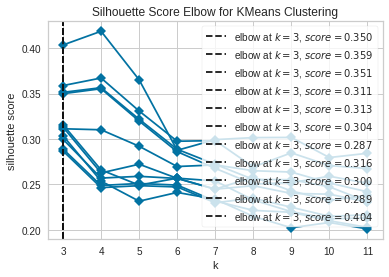

('acousticness', 'danceability', 'instrumentalness', 'liveness', 'tempo')
('acousticness', 'danceability', 'instrumentalness', 'liveness', 'valence')
('acousticness', 'danceability', 'instrumentalness', 'speechiness', 'tempo')


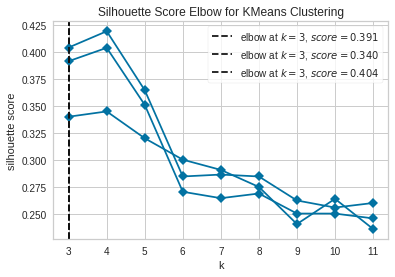

('acousticness', 'danceability', 'instrumentalness', 'speechiness', 'valence')
('acousticness', 'danceability', 'instrumentalness', 'tempo', 'valence')
('acousticness', 'danceability', 'liveness', 'speechiness', 'tempo')
('acousticness', 'danceability', 'liveness', 'speechiness', 'valence')
('acousticness', 'danceability', 'liveness', 'tempo', 'valence')
('acousticness', 'danceability', 'speechiness', 'tempo', 'valence')
('acousticness', 'energy', 'instrumentalness', 'liveness', 'speechiness')
('acousticness', 'energy', 'instrumentalness', 'liveness', 'tempo')
('acousticness', 'energy', 'instrumentalness', 'liveness', 'valence')
('acousticness', 'energy', 'instrumentalness', 'speechiness', 'tempo')
('acousticness', 'energy', 'instrumentalness', 'speechiness', 'valence')
('acousticness', 'energy', 'instrumentalness', 'tempo', 'valence')
('acousticness', 'energy', 'liveness', 'speechiness', 'tempo')
('acousticness', 'energy', 'liveness', 'speechiness', 'valence')
('acousticness', 'energy

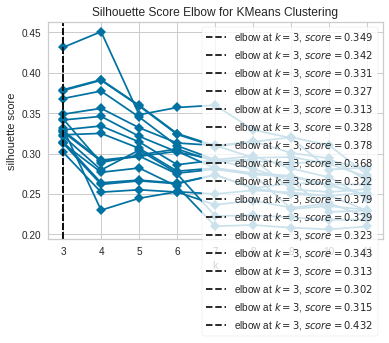

('acousticness', 'instrumentalness', 'liveness', 'speechiness', 'valence')
('acousticness', 'instrumentalness', 'liveness', 'tempo', 'valence')
('acousticness', 'instrumentalness', 'speechiness', 'tempo', 'valence')
('acousticness', 'liveness', 'speechiness', 'tempo', 'valence')
('danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness')
('danceability', 'energy', 'instrumentalness', 'liveness', 'tempo')
('danceability', 'energy', 'instrumentalness', 'liveness', 'valence')
('danceability', 'energy', 'instrumentalness', 'speechiness', 'tempo')
('danceability', 'energy', 'instrumentalness', 'speechiness', 'valence')
('danceability', 'energy', 'instrumentalness', 'tempo', 'valence')
('danceability', 'energy', 'liveness', 'speechiness', 'tempo')
('danceability', 'energy', 'liveness', 'speechiness', 'valence')
('danceability', 'energy', 'liveness', 'tempo', 'valence')
('danceability', 'energy', 'speechiness', 'tempo', 'valence')
('danceability', 'instrumentalness', 'liveness',

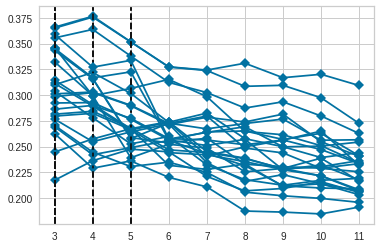

In [ ]:
column_names = ["features", "score", "elbow"]
df3 = pd.DataFrame(columns = column_names)
for comb in list(audio_combo):
  print(comb)
  comb = audio_features[[comb[0], comb[1], comb[2], comb[3], comb[4]]]
  min_max_scaler = MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(comb.values)

  model = KMeans(random_state=0)
  visualizer = KElbowVisualizer(model, k=(3,12), metric='silhouette', timings=False)
  visualizer.fit(x_scaled)
  score = visualizer.elbow_score_
  value = visualizer.elbow_value_
  if score>0.4:
      visualizer.show()
      idx = comb.columns
      mylist = idx.tolist()
      dict = {
          "features": mylist,
          "score": score,
          "elbow": value
      }
      df3 = df3.append(dict, ignore_index=True)

# print(df3)


In [ ]:
# df with combination scores above >0.4.
df3


,features,score,elbow
0,"[acousticness, danceability, instrumentalness,...",0.403577,3
1,"[acousticness, danceability, instrumentalness,...",0.404104,3
2,"[acousticness, instrumentalness, liveness, spe...",0.431529,3


We have achieved a better clustering solution compared to baseline suggesting 3 cluster with score 0.43

# Approach 2

1. create a set of all possible combinations of the audio features using three features at a time.
2. For each combination, find elbow score, elbow value.
    - elbow score(silhollette score) gives how well the data is clustered for the combination
    - elbow value - best number of clusters for the combination
3. Find the comb with best score and corresponding clusters
4. Try other clustring models using clusters with best score




In [ ]:
import itertools
columns = audio_features.columns
audio_combo = itertools.combinations(columns, 3)
audio_combo = set(map(lambda x: tuple(sorted(x)),audio_combo))


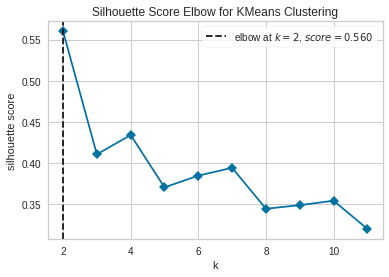

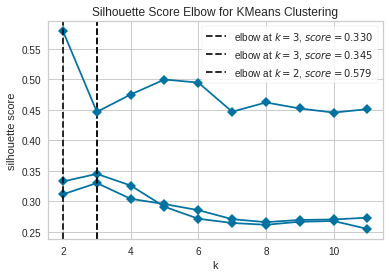

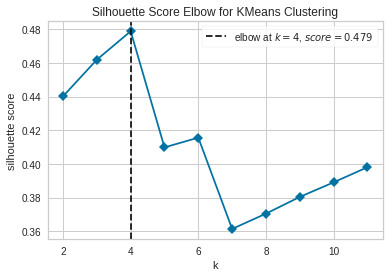

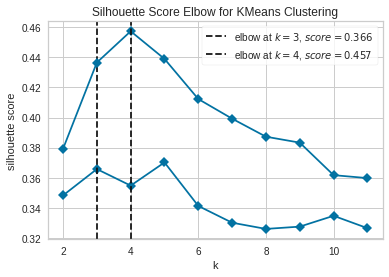

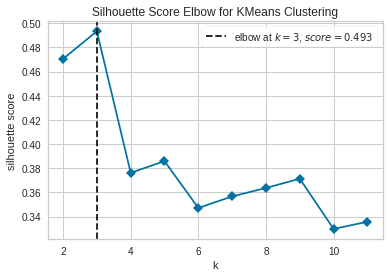

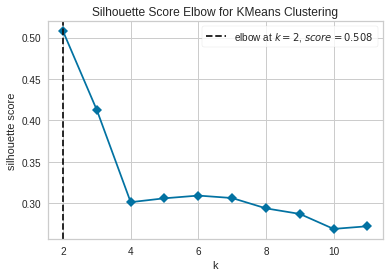

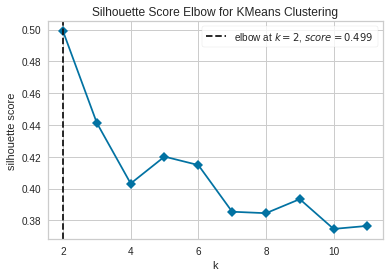

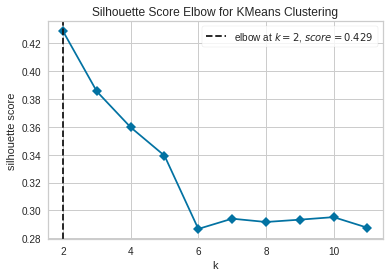

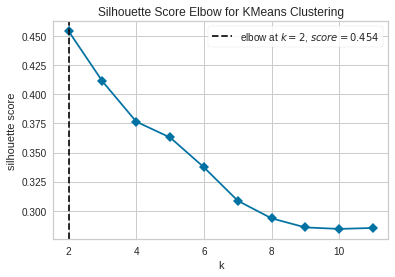

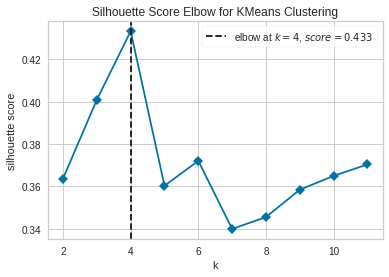

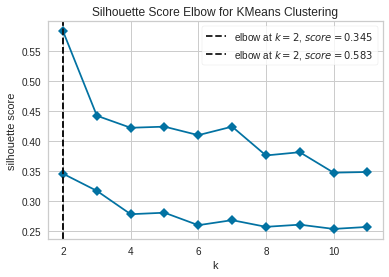

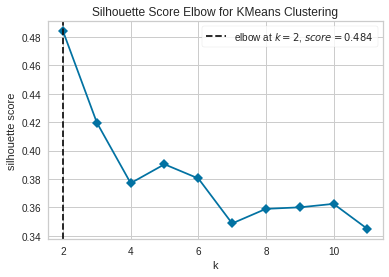

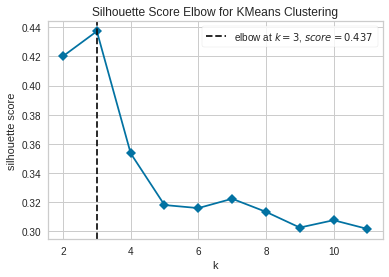

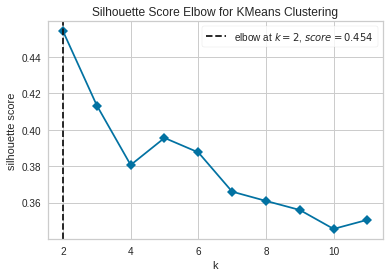

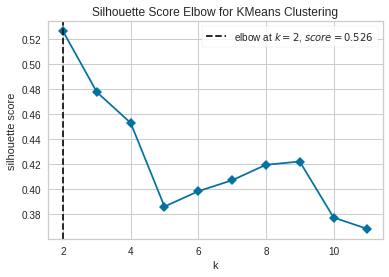

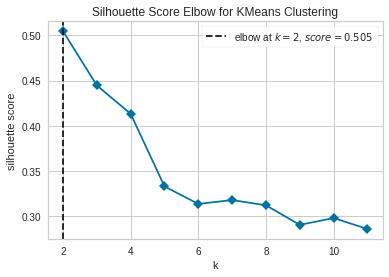

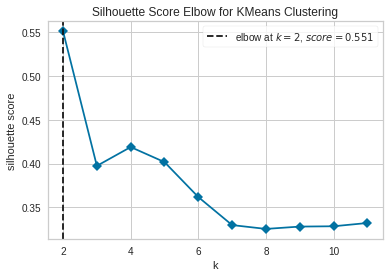

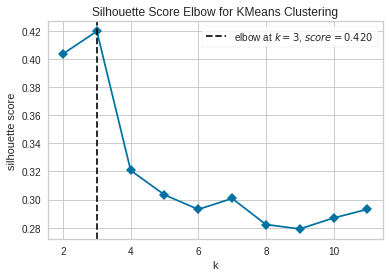

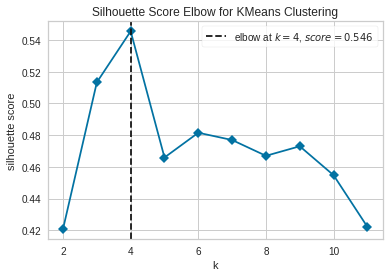

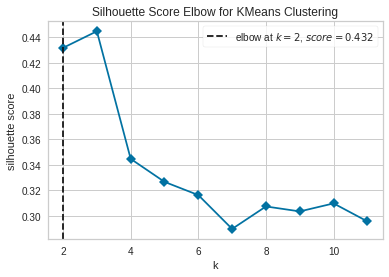

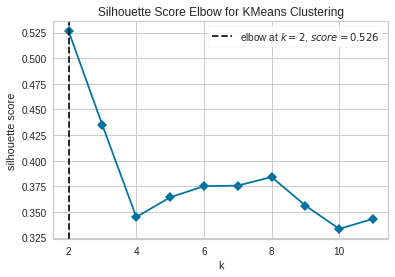

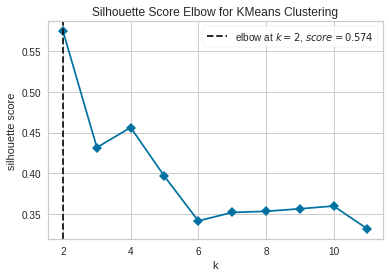

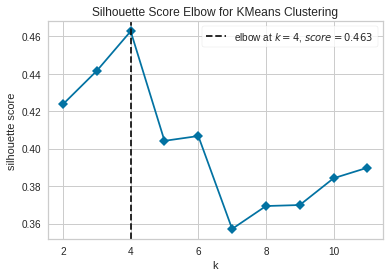

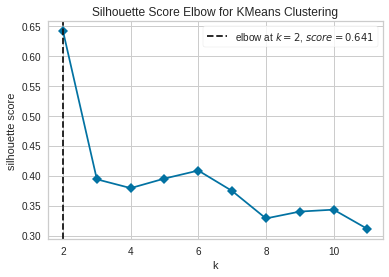

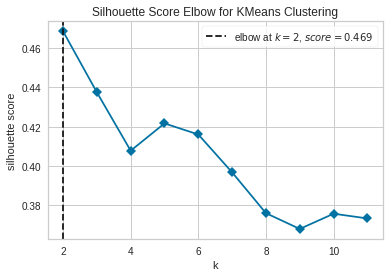

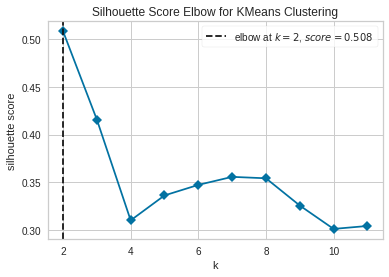

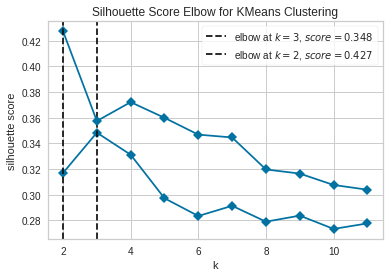

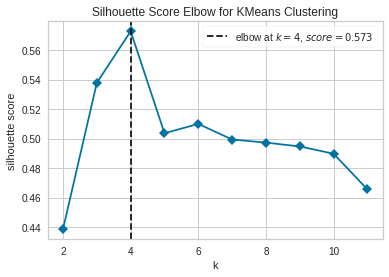

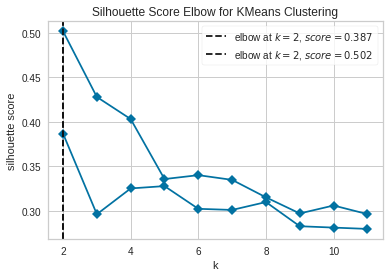

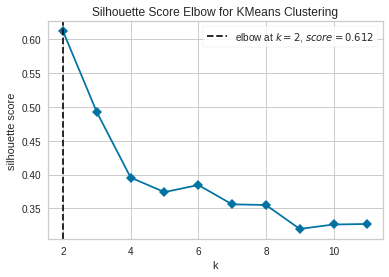

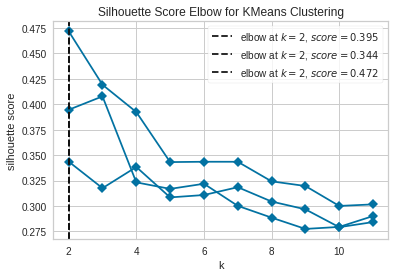

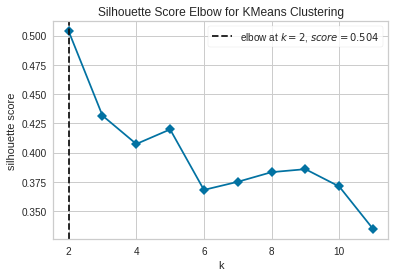

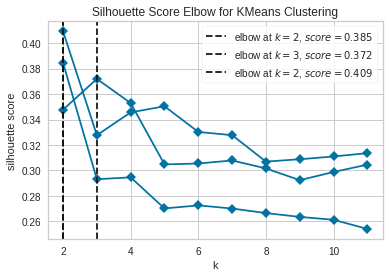

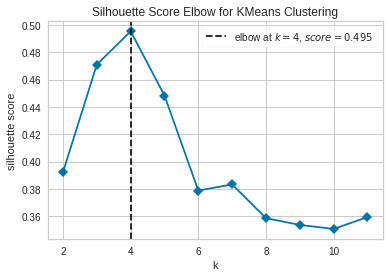

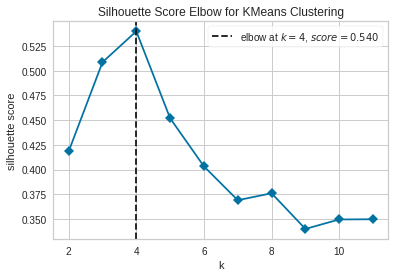

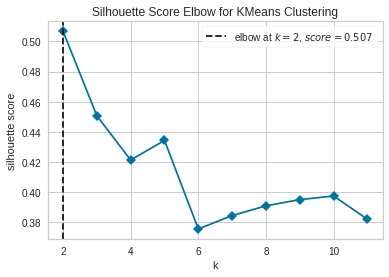

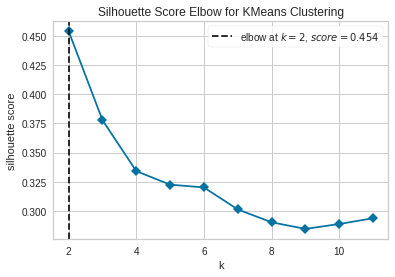

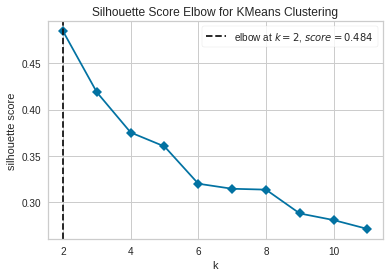

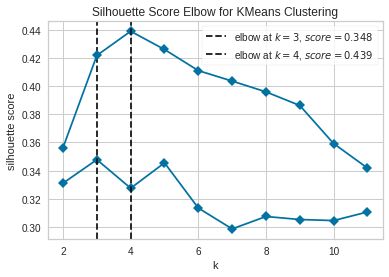

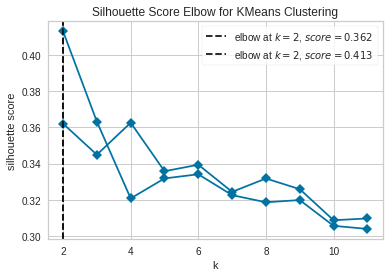

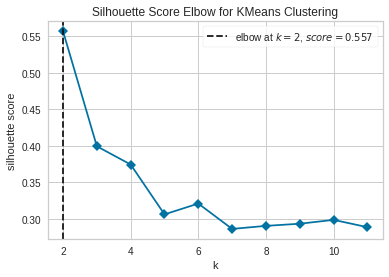

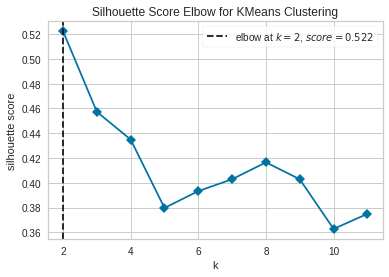

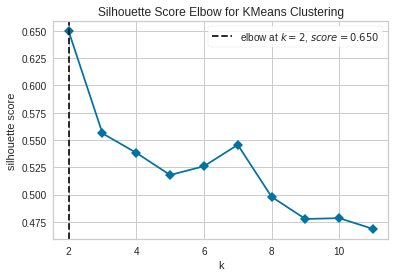

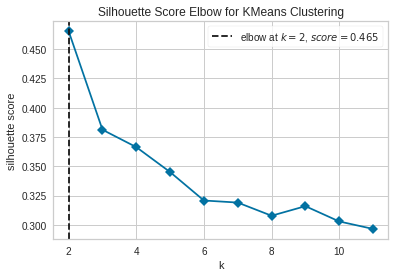

                                          features     score elbow
0       [danceability, instrumentalness, liveness]  0.560190     2
1            [acousticness, liveness, speechiness]  0.579194     2
2                 [liveness, speechiness, valence]  0.478790     4
3         [acousticness, energy, instrumentalness]  0.457394     4
4                   [liveness, speechiness, tempo]  0.493357     3
5              [acousticness, danceability, tempo]  0.507602     2
6              [acousticness, energy, speechiness]  0.498964     2
7            [acousticness, danceability, valence]  0.428521     2
8                   [acousticness, tempo, valence]  0.454124     2
9            [danceability, liveness, speechiness]  0.433346     4
10   [danceability, instrumentalness, speechiness]  0.582965     2
11                [acousticness, energy, liveness]  0.484144     2
12                    [energy, speechiness, tempo]  0.437206     3
13               [acousticness, liveness, valence]  0.454043  

In [ ]:
column_names = ["features", "score", "elbow"]
df3 = pd.DataFrame(columns = column_names)
for comb in list(audio_combo):
  comb = audio_features[[comb[0], comb[1], comb[2]]]
  min_max_scaler = MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(comb.values)

  model = KMeans(random_state=0)
  visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings=False)
  visualizer.fit(x_scaled)
  score = visualizer.elbow_score_
  value = visualizer.elbow_value_
  
  if score>0.4:
      visualizer.show()
      idx = comb.columns
      mylist = idx.tolist()
      dict = {
          "features": mylist,
          "score": score,
          "elbow": value
      }
      df3 = df3.append(dict, ignore_index=True)

print(df3)


In [ ]:
df3

,features,score,elbow
0,"[acousticness, danceability, tempo]",0.507602,2
1,"[acousticness, speechiness, valence]",0.468609,2
2,"[danceability, liveness, speechiness]",0.433346,4
3,"[acousticness, energy, valence]",0.413005,2
4,"[instrumentalness, tempo, valence]",0.504518,2
5,"[acousticness, instrumentalness, valence]",0.438880,4
6,"[instrumentalness, speechiness, tempo]",0.640738,2
7,"[acousticness, speechiness, tempo]",0.574174,2
8,"[acousticness, energy, speechiness]",0.498964,2
9,"[acousticness, liveness, speechiness]",0.579194,2


The above dataframe lists the  feature combinations and their corresponding ideal number of clusters and the quality score of these clusters having score>0.4.



Out of all combinations, The combination ['acousticness', 'instrumentalness', 'speechiness'] suggested creating 4 clusters and had a score of 0.57. This is the one used for clustering the music tracks.

This approach of using small set of combination actually working better than baselines. The score has improved by 2 times compared to baselines.

let's build the different clustering models with the chosen clusters and feature combination and predict the cluster into which each music track goes into. Add the cluster prediction to the dataframe.

## K-Means model

In [ ]:
cols = ['acousticness', 'instrumentalness', 'speechiness']
min_max_scaler = MinMaxScaler()
audio_features_scaled = min_max_scaler.fit_transform(audio_features[cols].values)

# K-Means
kmeans = KMeans(n_clusters=4, random_state=0)
y_predicted = kmeans.fit_predict(x_scaled)
audio_features['cluster'] = y_predicted

Text(0.5, 1.0, 'Distribution of music tracks by cluster')

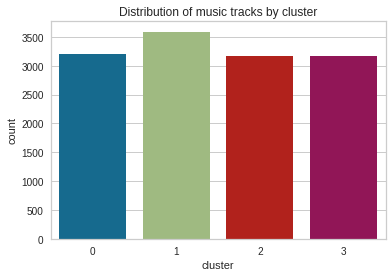

In [ ]:
sns.countplot(x='cluster', data=audio_features)
plt.title("Distribution of music tracks by cluster")

Now reduce the dimensionality of the dataframe to visualize how the data is grouped ito clusters.

Text(0.5, 1.0, 'Clustering by KMeans (k=4)')

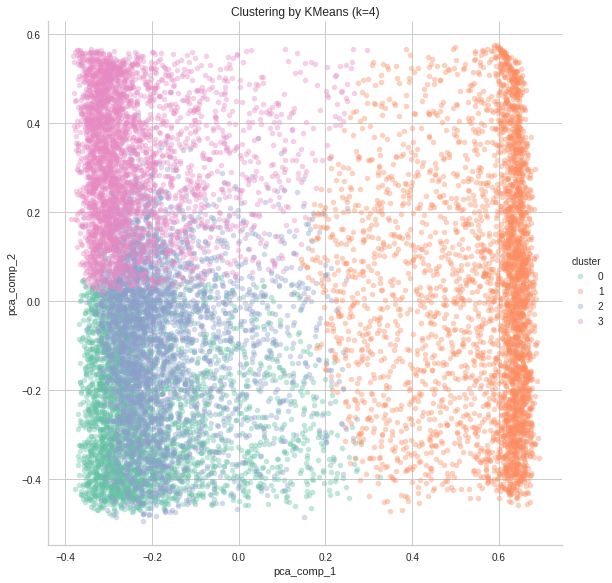

In [ ]:
# evaluate visually
pca = PCA(n_components=2)
x = pca.fit_transform(x_scaled)
comp_x, comp_y = zip(*x)

audio_features['pca_comp_1'] = comp_x
audio_features['pca_comp_2'] = comp_y
sns.lmplot(data=audio_features, x='pca_comp_1', y='pca_comp_2', hue='cluster', fit_reg=False, height=8, palette='Set2', scatter_kws={'alpha':0.4, 's':30})
plt.title("Clustering by KMeans (k=4)")

Try other clustering models with the hope of imcreasing the performanc bit more.

## Hierarchical Clustering Model

In [ ]:
# Defining the agglomerative clustering using complete linkage method

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=4)
# Fit model
clusters = agg_cluster.fit_predict(audio_features_scaled)
# evaluate model using silhouette score
print("The silhouette score of the Agglomerative {} clusters solution - complete linkage method: {}"
      .format(4, metrics.silhouette_score(audio_features_scaled, clusters, metric='euclidean')))
print("------------------------------------------------")


# Defining the agglomerative clustering using ward linkage method
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=4)
# Fit model
clusters = agg_cluster.fit_predict(audio_features_scaled)
# evaluate model using silhouette score
print("The silhouette score of the Agglomerative {} cluster solution - ward linkage method: {}"
      .format(4, metrics.silhouette_score(audio_features_scaled, clusters, metric='euclidean')))
print("------------------------------------------------")


# Defining the agglomerative clustering using average linkage method
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=4)
# Fit model
clusters = agg_cluster.fit_predict(audio_features_scaled)
# evaluate model using silhouette score
print("The silhouette score of the {} Agglomerative cluster solution - average linkage method: {}"
      .format(4, metrics.silhouette_score(audio_features_scaled, clusters, metric='euclidean')))
print("------------------------------------------------")

The silhouette score of the Agglomerative 4 clusters solution - complete linkage method: 0.37830523707234104
------------------------------------------------
The silhouette score of the Agglomerative 4 cluster solution - ward linkage method: 0.5394590560235261
------------------------------------------------
The silhouette score of the 4 Agglomerative cluster solution - average linkage method: 0.2817379543273221
------------------------------------------------


## Gaussian Model

In [ ]:
covariance_types = ['full', 'tied', 'diag', 'spherical']
for covariance_type in covariance_types:
  gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type=covariance_type)

  # Fit model
  clusters = gmm_cluster.fit_predict(audio_features_scaled)
  # evaluate model using silhouette score
  print("The silhouette score of the GMM solution  of covariance_type {}: {}"
        .format(covariance_type, metrics.silhouette_score(audio_features_scaled, clusters, metric='euclidean')))

The silhouette score of the GMM solution  of covariance_type full: 0.3394782240685168
The silhouette score of the GMM solution  of covariance_type tied: 0.4371575043772147
The silhouette score of the GMM solution  of covariance_type diag: 0.3351766052625359
The silhouette score of the GMM solution  of covariance_type spherical: 0.4383976577632535


Out of three clustering models tried, K-means solution is the best performing model with the score of 0.57.

# Conclusion

In this project, I was able to cluster the music data using different clustering techniques such as K-means, Hierarchical, Gaussian models. Out of the diffrent techniques used, K-means achieved best clustering with score of 0.57 where music tracks are segmented to 4 clusters. Integrating this algorithm to recommendation engines for music services like Spotify can improve the predicting more suitable songs to its users.

# Next steps

1. Need to imrove the performance of the model by
    - Investigating other music related features like low audio level features and adding them to the existing model.